In [1]:
%env CUDA_DEVICE_ORDER=PCI_BUS_ID
#%env CUDA_VISIBLE_DEVICES=5

env: CUDA_DEVICE_ORDER=PCI_BUS_ID


In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
import omegaconf
import numpy as np
import matplotlib.pyplot as plt
from ganime.data.kny import KNYImage
from ganime.data.mnist import MovingMNIST
from ganime.utils.statistics import dataset_statistics
from ganime.visualization.videos import display_videos
from ganime.visualization.images import display_images
from ganime.model.vqgan_clean.net2net import Net2Net
import tensorflow as tf
import tensorflow_addons as tfa
from datetime import datetime
from tqdm import tqdm
from pyprojroot.pyprojroot import here
#tf.get_logger().setLevel('ERROR')

In [4]:
for device in tf.config.list_physical_devices("GPU"):
    tf.config.experimental.set_memory_growth(device, True)

In [5]:
strategy = tf.distribute.MultiWorkerMirroredStrategy()

2022-06-01 04:28:25.223584: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-06-01 04:28:38.392606: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1525] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 14252 MB memory:  -> device: 0, name: NVIDIA RTX A4000, pci bus id: 0000:01:00.0, compute capability: 8.6
2022-06-01 04:28:38.419622: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1525] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 14252 MB memory:  -> device: 1, name: NVIDIA RTX A4000, pci bus id: 0000:25:00.0, compute capability: 8.6
2022-06-01 04:28:38.439605: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1525] Created device /job:localhost/replica:0/task:0/device:GPU:2 w

INFO:tensorflow:Single-worker MultiWorkerMirroredStrategy with local_devices = ('/device:GPU:0', '/device:GPU:1', '/device:GPU:2', '/device:GPU:3', '/device:GPU:4', '/device:GPU:5', '/device:GPU:6', '/device:GPU:7'), communication = CommunicationImplementation.AUTO


In [6]:
cfg = omegaconf.OmegaConf.load(here("configs/moving_mnist_image_transformer.yaml"))
#cfg = omegaconf.OmegaConf.load(here("configs/default_transformer.yaml"))
batch_size = 8

In [7]:
train_ds = MovingMNIST("../../../data", batch_size=batch_size, split="train")
test_ds = MovingMNIST("../../../data", batch_size=batch_size, split="test")

In [8]:
with strategy.scope():
    model = Net2Net(**cfg["model"])

Working with z of shape (1, 128, 16, 16) = 32768 dimensions.


2022-06-01 04:28:47.071000: I tensorflow/stream_executor/cuda/cuda_dnn.cc:366] Loaded cuDNN version 8101
2022-06-01 04:28:53.214722: I tensorflow/stream_executor/cuda/cuda_blas.cc:1774] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.


VQLPIPSWithDiscriminator running with hinge loss.


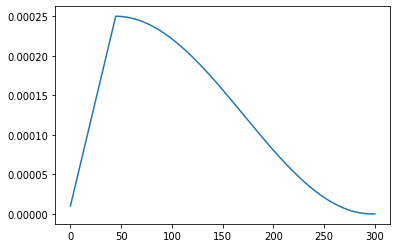

In [9]:
lrs = [model.scheduled_lrs(i) for i in range(71 * 300)]
xs = np.linspace(0, 300, len(lrs))
plt.plot(xs, lrs)

In [10]:
from ganime.utils.callbacks import TensorboardImage, get_logdir
import os

logdir = get_logdir("../../../logs/ganime/", experiment_name="transformer_mnist_video")
# Define the basic TensorBoard callback.
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=logdir)
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor="val_loss",
    min_delta=0.001,
    patience=10,
    restore_best_weights=True,
)
checkpointing = tf.keras.callbacks.ModelCheckpoint(os.path.join(logdir, "checkpoint", "checkpoint"), monitor='val_loss', save_best_only=True, save_weights_only=True)
callbacks = [tensorboard_callback, early_stopping, checkpointing]

In [11]:
#with strategy.scope():
#    model.compile(optimizer=tfa.optimizers.AdamW(
#        learning_rate=1e-3, weight_decay=1e-4
#    ))

display_images(train_ds[0][0], 1, 3)
plt.show()

display_images(train_ds[0][1], 1, 3)
plt.show()

In [12]:
with strategy.scope():
    model.first_stage_model.build(input_shape=(None, *train_ds[0][0].shape[2:]))
    model.cond_stage_model.build(input_shape=(None, *train_ds[0][0].shape[2:]))

INFO:tensorflow:Collective all_reduce tensors: 1 all_reduces, num_devices = 8, group_size = 8, implementation = AUTO, num_packs = 1
INFO:tensorflow:Collective all_reduce tensors: 1 all_reduces, num_devices = 8, group_size = 8, implementation = AUTO, num_packs = 1
INFO:tensorflow:Collective all_reduce tensors: 1 all_reduces, num_devices = 8, group_size = 8, implementation = AUTO, num_packs = 1
INFO:tensorflow:Collective all_reduce tensors: 1 all_reduces, num_devices = 8, group_size = 8, implementation = AUTO, num_packs = 1
INFO:tensorflow:Collective all_reduce tensors: 1 all_reduces, num_devices = 8, group_size = 8, implementation = AUTO, num_packs = 1
INFO:tensorflow:Collective all_reduce tensors: 1 all_reduces, num_devices = 8, group_size = 8, implementation = AUTO, num_packs = 1
INFO:tensorflow:Collective all_reduce tensors: 1 all_reduces, num_devices = 8, group_size = 8, implementation = AUTO, num_packs = 1
INFO:tensorflow:Collective all_reduce tensors: 1 all_reduces, num_devices = 

In [13]:
with strategy.scope():
    video = model(train_ds[0])

In [14]:
model.summary()

Model: "net2_net"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 gpt (GPT)                   multiple                  84813312  
                                                                 
 vqgan (VQGAN)               multiple                  20186956  
                                                                 
Total params: 105,000,270
Trainable params: 104,998,468
Non-trainable params: 1,802
_________________________________________________________________


In [15]:
model.fit(train_ds, validation_data=test_ds, steps_per_epoch=8, validation_steps=8, epochs=300, callbacks=callbacks)

2022-06-01 04:29:38.562209: W tensorflow/core/grappler/optimizers/data/auto_shard.cc:766] AUTO sharding policy will apply DATA sharding policy as it failed to apply FILE sharding policy because of the following reason: Did not find a shardable source, walked to a node which is not a dataset: name: "FlatMapDataset/_2"
op: "FlatMapDataset"
input: "TensorDataset/_1"
attr {
  key: "Targuments"
  value {
    list {
    }
  }
}
attr {
  key: "_cardinality"
  value {
    i: -2
  }
}
attr {
  key: "f"
  value {
    func {
      name: "__inference_Dataset_flat_map_flat_map_fn_647745"
    }
  }
}
attr {
  key: "metadata"
  value {
    s: "\n\020FlatMapDataset:1"
  }
}
attr {
  key: "output_shapes"
  value {
    list {
      shape {
        dim {
          size: -1
        }
        dim {
          size: -1
        }
        dim {
          size: -1
        }
        dim {
          size: -1
        }
        dim {
          size: -1
        }
      }
      shape {
        dim {
          size: -

Epoch 1/300
INFO:tensorflow:Collective all_reduce tensors: 132 all_reduces, num_devices = 8, group_size = 8, implementation = AUTO, num_packs = 1
INFO:tensorflow:Collective all_reduce IndexedSlices: 2 all_reduces, num_devices =8, group_size = 8, implementation = AUTO
INFO:tensorflow:Collective all_reduce tensors: 1 all_reduces, num_devices = 8, group_size = 8, implementation = AUTO, num_packs = 1
INFO:tensorflow:Collective all_reduce tensors: 1 all_reduces, num_devices = 8, group_size = 8, implementation = AUTO, num_packs = 1
INFO:tensorflow:Collective all_reduce tensors: 1 all_reduces, num_devices = 8, group_size = 8, implementation = AUTO, num_packs = 1
INFO:tensorflow:Collective all_reduce tensors: 132 all_reduces, num_devices = 8, group_size = 8, implementation = AUTO, num_packs = 1
INFO:tensorflow:Collective all_reduce IndexedSlices: 2 all_reduces, num_devices =8, group_size = 8, implementation = AUTO
INFO:tensorflow:Collective all_reduce tensors: 1 all_reduces, num_devices = 8, g

2022-06-01 05:15:49.115947: I tensorflow/stream_executor/cuda/cuda_dnn.cc:366] Loaded cuDNN version 8101
2022-06-01 05:15:53.004310: I tensorflow/stream_executor/cuda/cuda_dnn.cc:366] Loaded cuDNN version 8101
2022-06-01 05:15:55.917932: I tensorflow/stream_executor/cuda/cuda_dnn.cc:366] Loaded cuDNN version 8101
2022-06-01 05:16:00.046239: I tensorflow/stream_executor/cuda/cuda_dnn.cc:366] Loaded cuDNN version 8101
2022-06-01 05:16:04.207533: I tensorflow/stream_executor/cuda/cuda_dnn.cc:366] Loaded cuDNN version 8101
2022-06-01 05:16:11.254517: I tensorflow/stream_executor/cuda/cuda_dnn.cc:366] Loaded cuDNN version 8101
2022-06-01 05:16:11.703282: I tensorflow/stream_executor/cuda/cuda_dnn.cc:366] Loaded cuDNN version 8101
2022-06-01 05:16:20.901931: W tensorflow/core/common_runtime/bfc_allocator.cc:275] Allocator (GPU_5_bfc) ran out of memory trying to allocate 2.06GiB with freed_by_count=0. The caller indicates that this is not a failure, but may mean that there could be performanc

8/8 [==============================] - ETA: 0s - loss: 114.2974

2022-06-01 05:18:25.480355: W tensorflow/core/grappler/optimizers/data/auto_shard.cc:766] AUTO sharding policy will apply DATA sharding policy as it failed to apply FILE sharding policy because of the following reason: Did not find a shardable source, walked to a node which is not a dataset: name: "FlatMapDataset/_2"
op: "FlatMapDataset"
input: "TensorDataset/_1"
attr {
  key: "Targuments"
  value {
    list {
    }
  }
}
attr {
  key: "_cardinality"
  value {
    i: -2
  }
}
attr {
  key: "f"
  value {
    func {
      name: "__inference_Dataset_flat_map_flat_map_fn_3106122"
    }
  }
}
attr {
  key: "metadata"
  value {
    s: "\n\021FlatMapDataset:63"
  }
}
attr {
  key: "output_shapes"
  value {
    list {
      shape {
        dim {
          size: -1
        }
        dim {
          size: -1
        }
        dim {
          size: -1
        }
        dim {
          size: -1
        }
        dim {
          size: -1
        }
      }
      shape {
        dim {
          size:

INFO:tensorflow:Collective all_reduce tensors: 1 all_reduces, num_devices = 8, group_size = 8, implementation = AUTO, num_packs = 1
INFO:tensorflow:Collective all_reduce tensors: 1 all_reduces, num_devices = 8, group_size = 8, implementation = AUTO, num_packs = 1


InvalidArgumentError: 9 root error(s) found.
  (0) INVALID_ARGUMENT:  logits and labels must have the same first dimension, got logits shape [81920,3] and labels shape [1]
	 [[node replica_7/sparse_categorical_crossentropy_19/SparseSoftmaxCrossEntropyWithLogits/SparseSoftmaxCrossEntropyWithLogits
 (defined at /home/abdalla/GANime/venv/lib/python3.8/site-packages/keras/backend.py:5113)
]]
	 [[group_deps/_24441]]
  (1) INVALID_ARGUMENT:  logits and labels must have the same first dimension, got logits shape [81920,3] and labels shape [1]
	 [[node replica_7/sparse_categorical_crossentropy_19/SparseSoftmaxCrossEntropyWithLogits/SparseSoftmaxCrossEntropyWithLogits
 (defined at /home/abdalla/GANime/venv/lib/python3.8/site-packages/keras/backend.py:5113)
]]
	 [[group_deps/_24425]]
  (2) INVALID_ARGUMENT:  logits and labels must have the same first dimension, got logits shape [81920,3] and labels shape [1]
	 [[node replica_7/sparse_categorical_crossentropy_19/SparseSoftmaxCrossEntropyWithLogits/SparseSoftmaxCrossEntropyWithLogits
 (defined at /home/abdalla/GANime/venv/lib/python3.8/site-packages/keras/backend.py:5113)
]]
	 [[div_no_nan/_24389]]
  (3) INVALID_ARGUMENT:  logits and labels must have the same first dimension, got logits shape [81920,3] and labels shape [1]
	 [[node replica_7/sparse_categorical_crossentropy_19/SparseSoftmaxCrossEntropyWithLogits/SparseSoftmaxCrossEntropyWithLogits
 (defined at /home/abdalla/GANime/venv/lib/python3.8/site-packages/keras/backend.py:5113)
]]
	 [[div_no_nan/_24381]]
  (4) INVALID_ARGUMENT:  logits and labels must have the same first dimension, got logits shape [81920,3] and labels shape [1]
	 [[node replica_7/sparse_categorical_crossentropy_19/SparseSoftmaxCrossEntropyWithLogits/SparseSoftmaxCrossEntropyWithLogits
 (defined at /home/abdalla/GANime/venv/lib/python3.8/site-packages/keras/backend.py:5113)
]]
	 [[div_no_nan/_24377]]
  (5) INVALID_ARGUMENT:  logits and labels must have the same first dimension, got logits shape [81920,3] and labels shape [1]
	 [[node replica_7/sparse_categorical_crossentropy_19/SparseSoftmaxCrossEntropyWithLogits/SparseSoftmaxCrossEntropyWithLogits
 (defined at /home/abdalla/GANime/venv/lib/python3.8/site-packages/keras/backend.py:5113)
]]
	 [[div_no_nan/_24373]]
  (6) INVALID_ARGUMENT:  logits and labels must have the same first dimension, got logits shape [81920,3] and labels shape [1]
	 [[node replica_7/sparse_categorical_crossentropy_19/SparseSoftmaxCrossEntropyWithLogits/SparseSoftmaxCrossEntropyWithLogits
 (defined at /home/abdalla/GANime/venv/lib/python3.8/site-packages/keras/backend.py:5113)
]]
	 [[div_no_nan/CollectiveReduceV2_11/_24341]]
  (7) INVALID_ARGUMENT:  logits and labels must have the same first dimension, got logits shape [81920,3] and labels shape [1]
	 [[node replica_7/sparse_categorical_crossentropy_19/SparseSoftmaxCrossEntropyWithLogits/SparseSoftmaxCrossEntropyWithLogits
 (defined at /home/abdalla/GANime/venv/lib/python3.8/site-packages/keras/backend.py:5113)
]]
	 [[GroupCrossDeviceControlEdges_0/Identity_9/_24473]]
  (8) INVALID_ARGUMENT:  logits and labels must have the same first dimension, got logits shape [81920,3] and labels shape [1]
	 [[node replica_7/sparse_categorical_crossentropy_19/SparseSoftmaxCrossEntropyWithLogits/SparseSoftmaxCrossEntropyWithLogits
 (defined at /home/abdalla/GANime/venv/lib/python3.8/site-packages/keras/backend.py:5113)
]]
0 successful operations.
0 derived errors ignored. [Op:__inference_test_function_3928655]

Errors may have originated from an input operation.
Input Source operations connected to node replica_7/sparse_categorical_crossentropy_19/SparseSoftmaxCrossEntropyWithLogits/SparseSoftmaxCrossEntropyWithLogits:
In[0] replica_7/sparse_categorical_crossentropy_19/Reshape_1 (defined at /home/abdalla/GANime/venv/lib/python3.8/site-packages/keras/backend.py:5109)	
In[1] replica_7/sparse_categorical_crossentropy_19/Reshape (defined at /home/abdalla/GANime/venv/lib/python3.8/site-packages/keras/backend.py:3561)

Operation defined at: (most recent call last)
>>>   File "/usr/lib/python3.8/threading.py", line 890, in _bootstrap
>>>     self._bootstrap_inner()
>>> 
>>>   File "/usr/lib/python3.8/threading.py", line 932, in _bootstrap_inner
>>>     self.run()
>>> 
>>>   File "/home/abdalla/GANime/venv/lib/python3.8/site-packages/keras/engine/training.py", line 1349, in run_step
>>>     outputs = model.test_step(data)
>>> 
>>>   File "/home/abdalla/GANime/ganime/model/vqgan_clean/net2net.py", line 273, in test_step
>>>     loss += tf.reduce_mean(self.loss_fn(y_true=target, y_pred=logits))
>>> 
>>>   File "/home/abdalla/GANime/venv/lib/python3.8/site-packages/keras/losses.py", line 141, in __call__
>>>     losses = call_fn(y_true, y_pred)
>>> 
>>>   File "/home/abdalla/GANime/venv/lib/python3.8/site-packages/keras/losses.py", line 245, in call
>>>     return ag_fn(y_true, y_pred, **self._fn_kwargs)
>>> 
>>>   File "/home/abdalla/GANime/venv/lib/python3.8/site-packages/keras/losses.py", line 1737, in sparse_categorical_crossentropy
>>>     return backend.sparse_categorical_crossentropy(
>>> 
>>>   File "/home/abdalla/GANime/venv/lib/python3.8/site-packages/keras/backend.py", line 5113, in sparse_categorical_crossentropy
>>>     res = tf.nn.sparse_softmax_cross_entropy_with_logits(
>>> 

Input Source operations connected to node replica_7/sparse_categorical_crossentropy_19/SparseSoftmaxCrossEntropyWithLogits/SparseSoftmaxCrossEntropyWithLogits:
In[0] replica_7/sparse_categorical_crossentropy_19/Reshape_1 (defined at /home/abdalla/GANime/venv/lib/python3.8/site-packages/keras/backend.py:5109)	
In[1] replica_7/sparse_categorical_crossentropy_19/Reshape (defined at /home/abdalla/GANime/venv/lib/python3.8/site-packages/keras/backend.py:3561)

Operation defined at: (most recent call last)
>>>   File "/usr/lib/python3.8/threading.py", line 890, in _bootstrap
>>>     self._bootstrap_inner()
>>> 
>>>   File "/usr/lib/python3.8/threading.py", line 932, in _bootstrap_inner
>>>     self.run()
>>> 
>>>   File "/home/abdalla/GANime/venv/lib/python3.8/site-packages/keras/engine/training.py", line 1349, in run_step
>>>     outputs = model.test_step(data)
>>> 
>>>   File "/home/abdalla/GANime/ganime/model/vqgan_clean/net2net.py", line 273, in test_step
>>>     loss += tf.reduce_mean(self.loss_fn(y_true=target, y_pred=logits))
>>> 
>>>   File "/home/abdalla/GANime/venv/lib/python3.8/site-packages/keras/losses.py", line 141, in __call__
>>>     losses = call_fn(y_true, y_pred)
>>> 
>>>   File "/home/abdalla/GANime/venv/lib/python3.8/site-packages/keras/losses.py", line 245, in call
>>>     return ag_fn(y_true, y_pred, **self._fn_kwargs)
>>> 
>>>   File "/home/abdalla/GANime/venv/lib/python3.8/site-packages/keras/losses.py", line 1737, in sparse_categorical_crossentropy
>>>     return backend.sparse_categorical_crossentropy(
>>> 
>>>   File "/home/abdalla/GANime/venv/lib/python3.8/site-packages/keras/backend.py", line 5113, in sparse_categorical_crossentropy
>>>     res = tf.nn.sparse_softmax_cross_entropy_with_logits(
>>> 

Input Source operations connected to node replica_7/sparse_categorical_crossentropy_19/SparseSoftmaxCrossEntropyWithLogits/SparseSoftmaxCrossEntropyWithLogits:
In[0] replica_7/sparse_categorical_crossentropy_19/Reshape_1 (defined at /home/abdalla/GANime/venv/lib/python3.8/site-packages/keras/backend.py:5109)	
In[1] replica_7/sparse_categorical_crossentropy_19/Reshape (defined at /home/abdalla/GANime/venv/lib/python3.8/site-packages/keras/backend.py:3561)

Operation defined at: (most recent call last)
>>>   File "/usr/lib/python3.8/threading.py", line 890, in _bootstrap
>>>     self._bootstrap_inner()
>>> 
>>>   File "/usr/lib/python3.8/threading.py", line 932, in _bootstrap_inner
>>>     self.run()
>>> 
>>>   File "/home/abdalla/GANime/venv/lib/python3.8/site-packages/keras/engine/training.py", line 1349, in run_step
>>>     outputs = model.test_step(data)
>>> 
>>>   File "/home/abdalla/GANime/ganime/model/vqgan_clean/net2net.py", line 273, in test_step
>>>     loss += tf.reduce_mean(self.loss_fn(y_true=target, y_pred=logits))
>>> 
>>>   File "/home/abdalla/GANime/venv/lib/python3.8/site-packages/keras/losses.py", line 141, in __call__
>>>     losses = call_fn(y_true, y_pred)
>>> 
>>>   File "/home/abdalla/GANime/venv/lib/python3.8/site-packages/keras/losses.py", line 245, in call
>>>     return ag_fn(y_true, y_pred, **self._fn_kwargs)
>>> 
>>>   File "/home/abdalla/GANime/venv/lib/python3.8/site-packages/keras/losses.py", line 1737, in sparse_categorical_crossentropy
>>>     return backend.sparse_categorical_crossentropy(
>>> 
>>>   File "/home/abdalla/GANime/venv/lib/python3.8/site-packages/keras/backend.py", line 5113, in sparse_categorical_crossentropy
>>>     res = tf.nn.sparse_softmax_cross_entropy_with_logits(
>>> 

Input Source operations connected to node replica_7/sparse_categorical_crossentropy_19/SparseSoftmaxCrossEntropyWithLogits/SparseSoftmaxCrossEntropyWithLogits:
In[0] replica_7/sparse_categorical_crossentropy_19/Reshape_1 (defined at /home/abdalla/GANime/venv/lib/python3.8/site-packages/keras/backend.py:5109)	
In[1] replica_7/sparse_categorical_crossentropy_19/Reshape (defined at /home/abdalla/GANime/venv/lib/python3.8/site-packages/keras/backend.py:3561)

Operation defined at: (most recent call last)
>>>   File "/usr/lib/python3.8/threading.py", line 890, in _bootstrap
>>>     self._bootstrap_inner()
>>> 
>>>   File "/usr/lib/python3.8/threading.py", line 932, in _bootstrap_inner
>>>     self.run()
>>> 
>>>   File "/home/abdalla/GANime/venv/lib/python3.8/site-packages/keras/engine/training.py", line 1349, in run_step
>>>     outputs = model.test_step(data)
>>> 
>>>   File "/home/abdalla/GANime/ganime/model/vqgan_clean/net2net.py", line 273, in test_step
>>>     loss += tf.reduce_mean(self.loss_fn(y_true=target, y_pred=logits))
>>> 
>>>   File "/home/abdalla/GANime/venv/lib/python3.8/site-packages/keras/losses.py", line 141, in __call__
>>>     losses = call_fn(y_true, y_pred)
>>> 
>>>   File "/home/abdalla/GANime/venv/lib/python3.8/site-packages/keras/losses.py", line 245, in call
>>>     return ag_fn(y_true, y_pred, **self._fn_kwargs)
>>> 
>>>   File "/home/abdalla/GANime/venv/lib/python3.8/site-packages/keras/losses.py", line 1737, in sparse_categorical_crossentropy
>>>     return backend.sparse_categorical_crossentropy(
>>> 
>>>   File "/home/abdalla/GANime/venv/lib/python3.8/site-packages/keras/backend.py", line 5113, in sparse_categorical_crossentropy
>>>     res = tf.nn.sparse_softmax_cross_entropy_with_logits(
>>> 

Input Source operations connected to node replica_7/sparse_categorical_crossentropy_19/SparseSoftmaxCrossEntropyWithLogits/SparseSoftmaxCrossEntropyWithLogits:
In[0] replica_7/sparse_categorical_crossentropy_19/Reshape_1 (defined at /home/abdalla/GANime/venv/lib/python3.8/site-packages/keras/backend.py:5109)	
In[1] replica_7/sparse_categorical_crossentropy_19/Reshape (defined at /home/abdalla/GANime/venv/lib/python3.8/site-packages/keras/backend.py:3561)

Operation defined at: (most recent call last)
>>>   File "/usr/lib/python3.8/threading.py", line 890, in _bootstrap
>>>     self._bootstrap_inner()
>>> 
>>>   File "/usr/lib/python3.8/threading.py", line 932, in _bootstrap_inner
>>>     self.run()
>>> 
>>>   File "/home/abdalla/GANime/venv/lib/python3.8/site-packages/keras/engine/training.py", line 1349, in run_step
>>>     outputs = model.test_step(data)
>>> 
>>>   File "/home/abdalla/GANime/ganime/model/vqgan_clean/net2net.py", line 273, in test_step
>>>     loss += tf.reduce_mean(self.loss_fn(y_true=target, y_pred=logits))
>>> 
>>>   File "/home/abdalla/GANime/venv/lib/python3.8/site-packages/keras/losses.py", line 141, in __call__
>>>     losses = call_fn(y_true, y_pred)
>>> 
>>>   File "/home/abdalla/GANime/venv/lib/python3.8/site-packages/keras/losses.py", line 245, in call
>>>     return ag_fn(y_true, y_pred, **self._fn_kwargs)
>>> 
>>>   File "/home/abdalla/GANime/venv/lib/python3.8/site-packages/keras/losses.py", line 1737, in sparse_categorical_crossentropy
>>>     return backend.sparse_categorical_crossentropy(
>>> 
>>>   File "/home/abdalla/GANime/venv/lib/python3.8/site-packages/keras/backend.py", line 5113, in sparse_categorical_crossentropy
>>>     res = tf.nn.sparse_softmax_cross_entropy_with_logits(
>>> 

Input Source operations connected to node replica_7/sparse_categorical_crossentropy_19/SparseSoftmaxCrossEntropyWithLogits/SparseSoftmaxCrossEntropyWithLogits:
In[0] replica_7/sparse_categorical_crossentropy_19/Reshape_1 (defined at /home/abdalla/GANime/venv/lib/python3.8/site-packages/keras/backend.py:5109)	
In[1] replica_7/sparse_categorical_crossentropy_19/Reshape (defined at /home/abdalla/GANime/venv/lib/python3.8/site-packages/keras/backend.py:3561)

Operation defined at: (most recent call last)
>>>   File "/usr/lib/python3.8/threading.py", line 890, in _bootstrap
>>>     self._bootstrap_inner()
>>> 
>>>   File "/usr/lib/python3.8/threading.py", line 932, in _bootstrap_inner
>>>     self.run()
>>> 
>>>   File "/home/abdalla/GANime/venv/lib/python3.8/site-packages/keras/engine/training.py", line 1349, in run_step
>>>     outputs = model.test_step(data)
>>> 
>>>   File "/home/abdalla/GANime/ganime/model/vqgan_clean/net2net.py", line 273, in test_step
>>>     loss += tf.reduce_mean(self.loss_fn(y_true=target, y_pred=logits))
>>> 
>>>   File "/home/abdalla/GANime/venv/lib/python3.8/site-packages/keras/losses.py", line 141, in __call__
>>>     losses = call_fn(y_true, y_pred)
>>> 
>>>   File "/home/abdalla/GANime/venv/lib/python3.8/site-packages/keras/losses.py", line 245, in call
>>>     return ag_fn(y_true, y_pred, **self._fn_kwargs)
>>> 
>>>   File "/home/abdalla/GANime/venv/lib/python3.8/site-packages/keras/losses.py", line 1737, in sparse_categorical_crossentropy
>>>     return backend.sparse_categorical_crossentropy(
>>> 
>>>   File "/home/abdalla/GANime/venv/lib/python3.8/site-packages/keras/backend.py", line 5113, in sparse_categorical_crossentropy
>>>     res = tf.nn.sparse_softmax_cross_entropy_with_logits(
>>> 

Input Source operations connected to node replica_7/sparse_categorical_crossentropy_19/SparseSoftmaxCrossEntropyWithLogits/SparseSoftmaxCrossEntropyWithLogits:
In[0] replica_7/sparse_categorical_crossentropy_19/Reshape_1 (defined at /home/abdalla/GANime/venv/lib/python3.8/site-packages/keras/backend.py:5109)	
In[1] replica_7/sparse_categorical_crossentropy_19/Reshape (defined at /home/abdalla/GANime/venv/lib/python3.8/site-packages/keras/backend.py:3561)

Operation defined at: (most recent call last)
>>>   File "/usr/lib/python3.8/threading.py", line 890, in _bootstrap
>>>     self._bootstrap_inner()
>>> 
>>>   File "/usr/lib/python3.8/threading.py", line 932, in _bootstrap_inner
>>>     self.run()
>>> 
>>>   File "/home/abdalla/GANime/venv/lib/python3.8/site-packages/keras/engine/training.py", line 1349, in run_step
>>>     outputs = model.test_step(data)
>>> 
>>>   File "/home/abdalla/GANime/ganime/model/vqgan_clean/net2net.py", line 273, in test_step
>>>     loss += tf.reduce_mean(self.loss_fn(y_true=target, y_pred=logits))
>>> 
>>>   File "/home/abdalla/GANime/venv/lib/python3.8/site-packages/keras/losses.py", line 141, in __call__
>>>     losses = call_fn(y_true, y_pred)
>>> 
>>>   File "/home/abdalla/GANime/venv/lib/python3.8/site-packages/keras/losses.py", line 245, in call
>>>     return ag_fn(y_true, y_pred, **self._fn_kwargs)
>>> 
>>>   File "/home/abdalla/GANime/venv/lib/python3.8/site-packages/keras/losses.py", line 1737, in sparse_categorical_crossentropy
>>>     return backend.sparse_categorical_crossentropy(
>>> 
>>>   File "/home/abdalla/GANime/venv/lib/python3.8/site-packages/keras/backend.py", line 5113, in sparse_categorical_crossentropy
>>>     res = tf.nn.sparse_softmax_cross_entropy_with_logits(
>>> 

Input Source operations connected to node replica_7/sparse_categorical_crossentropy_19/SparseSoftmaxCrossEntropyWithLogits/SparseSoftmaxCrossEntropyWithLogits:
In[0] replica_7/sparse_categorical_crossentropy_19/Reshape_1 (defined at /home/abdalla/GANime/venv/lib/python3.8/site-packages/keras/backend.py:5109)	
In[1] replica_7/sparse_categorical_crossentropy_19/Reshape (defined at /home/abdalla/GANime/venv/lib/python3.8/site-packages/keras/backend.py:3561)

Operation defined at: (most recent call last)
>>>   File "/usr/lib/python3.8/threading.py", line 890, in _bootstrap
>>>     self._bootstrap_inner()
>>> 
>>>   File "/usr/lib/python3.8/threading.py", line 932, in _bootstrap_inner
>>>     self.run()
>>> 
>>>   File "/home/abdalla/GANime/venv/lib/python3.8/site-packages/keras/engine/training.py", line 1349, in run_step
>>>     outputs = model.test_step(data)
>>> 
>>>   File "/home/abdalla/GANime/ganime/model/vqgan_clean/net2net.py", line 273, in test_step
>>>     loss += tf.reduce_mean(self.loss_fn(y_true=target, y_pred=logits))
>>> 
>>>   File "/home/abdalla/GANime/venv/lib/python3.8/site-packages/keras/losses.py", line 141, in __call__
>>>     losses = call_fn(y_true, y_pred)
>>> 
>>>   File "/home/abdalla/GANime/venv/lib/python3.8/site-packages/keras/losses.py", line 245, in call
>>>     return ag_fn(y_true, y_pred, **self._fn_kwargs)
>>> 
>>>   File "/home/abdalla/GANime/venv/lib/python3.8/site-packages/keras/losses.py", line 1737, in sparse_categorical_crossentropy
>>>     return backend.sparse_categorical_crossentropy(
>>> 
>>>   File "/home/abdalla/GANime/venv/lib/python3.8/site-packages/keras/backend.py", line 5113, in sparse_categorical_crossentropy
>>>     res = tf.nn.sparse_softmax_cross_entropy_with_logits(
>>> 

Input Source operations connected to node replica_7/sparse_categorical_crossentropy_19/SparseSoftmaxCrossEntropyWithLogits/SparseSoftmaxCrossEntropyWithLogits:
In[0] replica_7/sparse_categorical_crossentropy_19/Reshape_1 (defined at /home/abdalla/GANime/venv/lib/python3.8/site-packages/keras/backend.py:5109)	
In[1] replica_7/sparse_categorical_crossentropy_19/Reshape (defined at /home/abdalla/GANime/venv/lib/python3.8/site-packages/keras/backend.py:3561)

Operation defined at: (most recent call last)
>>>   File "/usr/lib/python3.8/threading.py", line 890, in _bootstrap
>>>     self._bootstrap_inner()
>>> 
>>>   File "/usr/lib/python3.8/threading.py", line 932, in _bootstrap_inner
>>>     self.run()
>>> 
>>>   File "/home/abdalla/GANime/venv/lib/python3.8/site-packages/keras/engine/training.py", line 1349, in run_step
>>>     outputs = model.test_step(data)
>>> 
>>>   File "/home/abdalla/GANime/ganime/model/vqgan_clean/net2net.py", line 273, in test_step
>>>     loss += tf.reduce_mean(self.loss_fn(y_true=target, y_pred=logits))
>>> 
>>>   File "/home/abdalla/GANime/venv/lib/python3.8/site-packages/keras/losses.py", line 141, in __call__
>>>     losses = call_fn(y_true, y_pred)
>>> 
>>>   File "/home/abdalla/GANime/venv/lib/python3.8/site-packages/keras/losses.py", line 245, in call
>>>     return ag_fn(y_true, y_pred, **self._fn_kwargs)
>>> 
>>>   File "/home/abdalla/GANime/venv/lib/python3.8/site-packages/keras/losses.py", line 1737, in sparse_categorical_crossentropy
>>>     return backend.sparse_categorical_crossentropy(
>>> 
>>>   File "/home/abdalla/GANime/venv/lib/python3.8/site-packages/keras/backend.py", line 5113, in sparse_categorical_crossentropy
>>>     res = tf.nn.sparse_softmax_cross_entropy_with_logits(
>>> 

Function call stack:
test_function -> test_function -> test_function -> test_function -> test_function -> test_function -> test_function -> test_function -> test_function
